In [1]:
import pandas as pd
import numpy as np
import modeltest as deep
import experiment as exp
import myutil as util

from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import importlib
importlib.reload(deep)
importlib.reload(exp)

<module 'experiment' from 'c:\\Users\\kyeongtaek\\generative_model\\veichle\\experiment.py'>

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17715019336980803682
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10062419968
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 657031424148273185
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [2]:
#파일 읽기
filepath_german_csv = 'xamain.csv'
d_german_df = pd.read_csv(filepath_german_csv)

#numpy 변환
d_german_np = np.array(d_german_df)

# sample 수, 특징 수 등 계산
n_row = d_german_np.shape[0]
n_features = d_german_np.shape[1]-1

# 입력과 출력 데이터 분리
x = d_german_np[:, :n_features]
y = d_german_np[:, n_features]

#정규화
x_norm = (x - np.min(x,0))/ (np.max(x,0) - np.min(x,0))
y_norm = (y - np.min(y,0))/ (np.max(y,0) - np.min(y,0))

3/3 [==============================] - 0s 44ms/step
0/10	 test_acc:0.8470588235294118


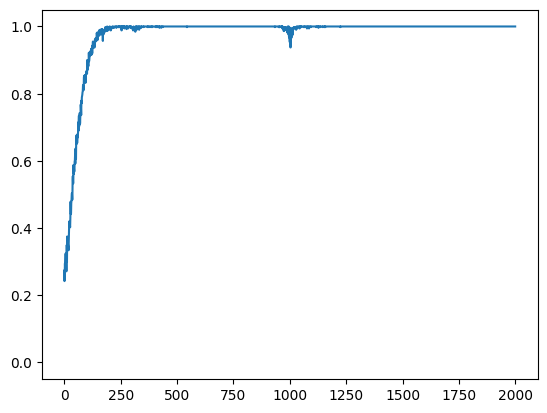

3/3 [==============================] - 0s 29ms/step
1/10	 test_acc:0.8690476190476191


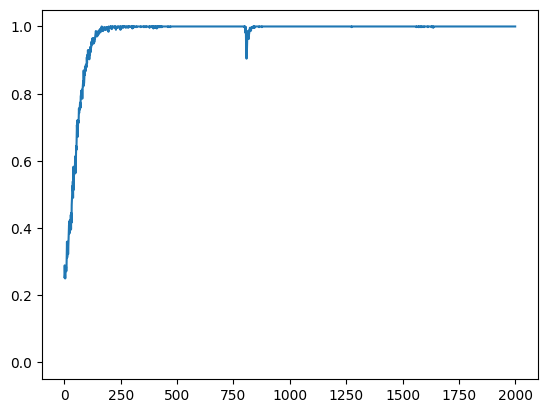

3/3 [==============================] - 0s 2ms/step
2/10	 test_acc:0.8117647058823529


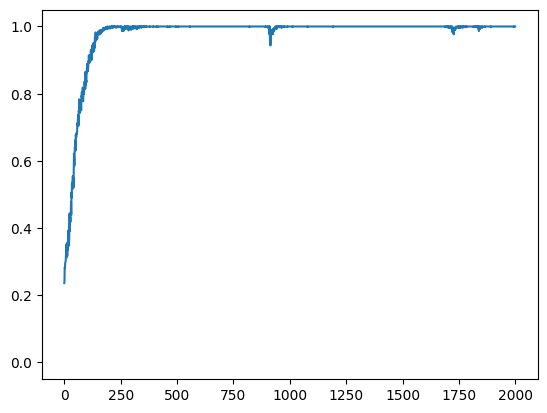

3/3 [==============================] - 0s 3ms/step
3/10	 test_acc:0.9047619047619048


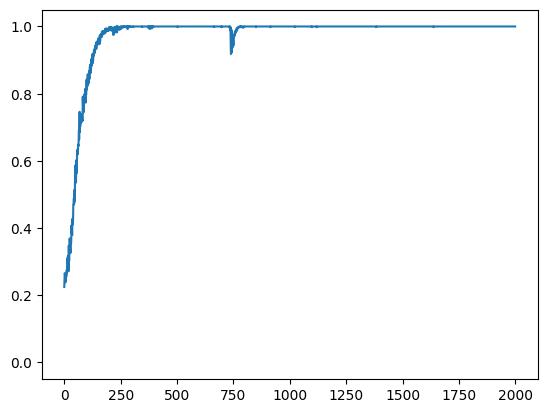

3/3 [==============================] - 0s 2ms/step
4/10	 test_acc:0.8235294117647058


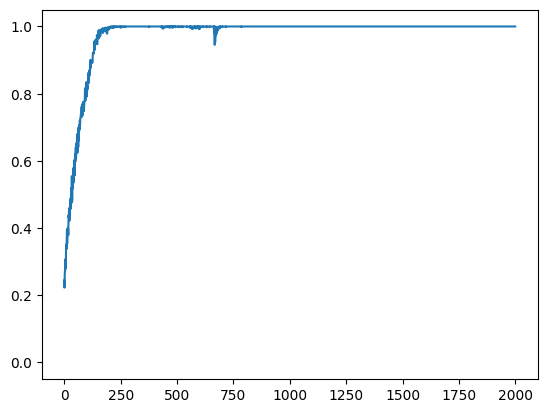

3/3 [==============================] - 0s 3ms/step
5/10	 test_acc:0.7647058823529411


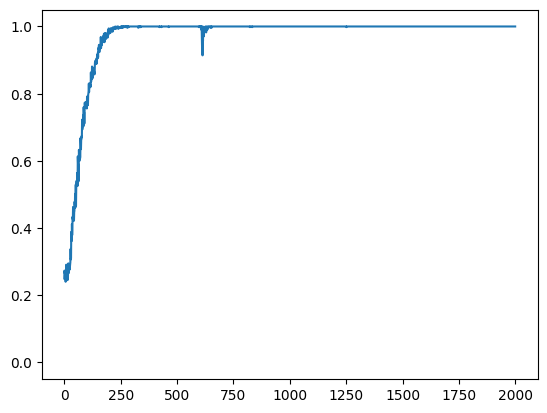

3/3 [==============================] - 0s 2ms/step
6/10	 test_acc:0.8095238095238095


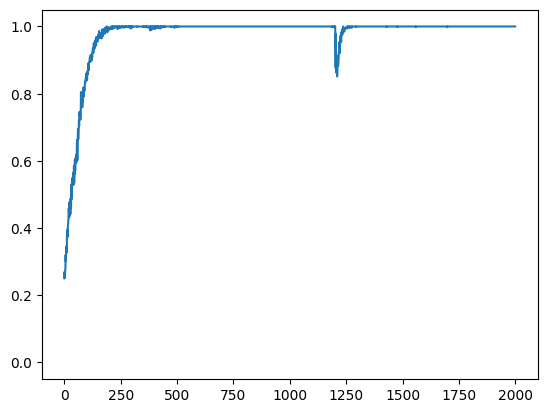

3/3 [==============================] - 0s 2ms/step
7/10	 test_acc:0.788235294117647


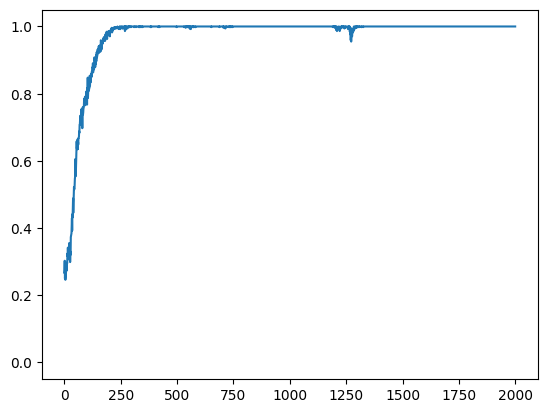

3/3 [==============================] - 0s 3ms/step
8/10	 test_acc:0.8571428571428571


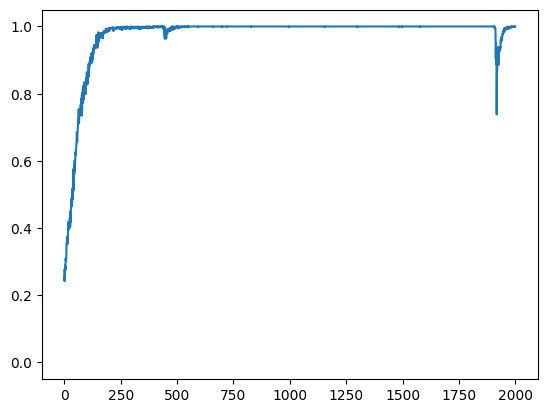

3/3 [==============================] - 0s 2ms/step
9/10	 test_acc:0.8470588235294118


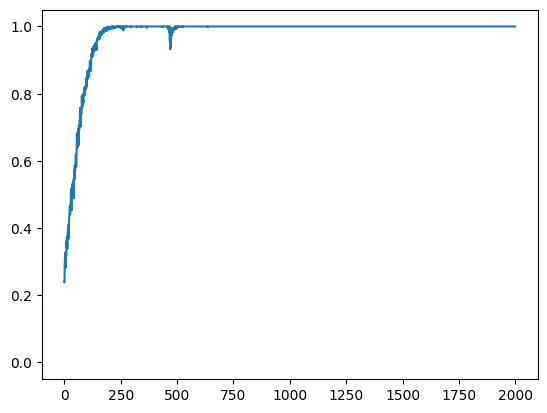

average accuracy : 0.832282913165266


In [3]:
# 10fold validation 수행여부
bTenFoldValidation = True
if not bTenFoldValidation:  # 학습 & 테스트를 1회만 수행하는 경우
    # 데이터 분할
    [x_train, x_val, x_test, y_train, y_val, y_test] = exp.split_data(x, y, test_ratio=0.0, val_ratio=0.1)

    # 모델 불러오기 & 컴파일
    m = deep.get_model_gen(x.shape[1:])
    m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # 학습시 사용하는 옵션
    train_options = exp.TrainParams(m, epochs=500, batch_size_per_class=32)

    # 학습
    result = exp.train_batches_with_random_selection(train_options, x_train, y_train, x_val, y_val)

    # 테스트
    if(x_test.shape[0] > 0):
        test_acc_tmp = np.sum(np.argmax(np.squeeze(result.model.predict(x_test)), -1) == y_test) / y_test.shape[0]
        print(f'test_acc:{test_acc_tmp}')
    # 결과 출력

    plt.plot(result.train_acc)
    plt.plot(result.val_acc)
    plt.show()

else:  # N fold Validation
    idx = np.array(range(n_row))
    np.random.shuffle(idx)  # 데이터 인덱스 섞기

    N = 10
    total = 0
    nClass = 4
    cm_sum = np.zeros([N, nClass, nClass])
    for i in range(N):
        # Train/Test 데이터 분할
        [x_train, x_test, y_train, y_test] = exp.split_data_for_N_fold_validation(x_norm, y, fold=N, idx=i)

        # 모델 불러오기 & 컴파일
        m = deep.get_model_gen(x.shape[1:])
        #m = deep.get_model(x.shape[1:])

        # m = deep.get_model(x.shape[1:])
        m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

        # 학습시 사용하는 옵션
        train_options = exp.TrainParams(m, epochs=2000, batch_size_per_class=128)

        # 학습
        result = exp.train_batches_with_random_selection(train_options, x_train, y_train, bVerbose=False)

        # 테스트
        o = np.argmax(np.squeeze(result.model.predict(x_test)), -1)
        test_acc_tmp = np.sum(o == y_test) / y_test.shape[0]
        cm = np.zeros([nClass, nClass])
        for j in range(y_test.shape[0]):
            cm[int(y_test[j]), int(o[j])] += 1  #Confusion Matrix 계산
        
        cm_sum += cm

        # 결과 출력
        print(f'{i}/{N}\t test_acc:{test_acc_tmp}')
        plt.plot(result.train_acc)
        plt.plot(result.val_acc)
        plt.show()
        total = total + test_acc_tmp

ave = total/10
print(f'average accuracy : {ave}')

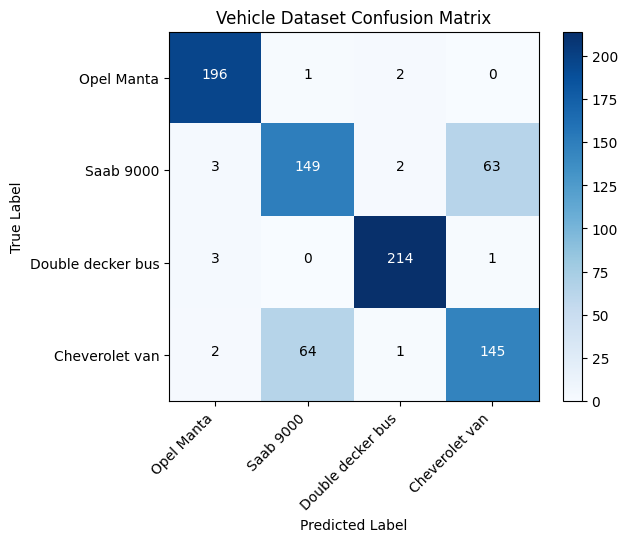

In [4]:
conf_matrix = cm_sum[0]
# 시각화
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Vehicle Dataset Confusion Matrix')
plt.colorbar()

classes = ['Opel Manta', 'Saab 9000', 'Double decker bus', 'Cheverolet van']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 각 셀에 숫자 표시
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(int(conf_matrix[i, j])),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

In [6]:
m.save('veichle_model.h5')

In [4]:
import tensorflow as tf

  # 모델 불러오기
load_model = tf.keras.models.load_model('veichle_model.h5')

In [5]:
import tensorflow as tf
cam_model = tf.keras.Model(load_model.input, outputs=(load_model.layers[-16].output, load_model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27_input (InputLayer)  [(None, 18)]             0         
                                                                 
 dense_27 (Dense)            (None, 5184)              98496     
                                                                 
 batch_normalization_18 (Bat  (None, 5184)             20736     
 chNormalization)                                                
                                                                 
 reshape_9 (Reshape)         (None, 9, 9, 64)          0         
                                                                 
 up_sampling2d_18 (UpSamplin  (None, 18, 18, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 18, 18, 32)        18464 

In [1]:
get_output = tf.keras.backend.function([load_model.layers[0].input],
                                       [load_model.layers[-16].output, load_model.layers[-1].output])
[conv_outputs, cam_predictions] = get_output([x_test])
class_weights = load_model.layers[-1].get_weights()[0]

conv_outputs.shape

NameError: name 'autoin' is not defined

In [7]:
print(conv_outputs.shape)
print(y_test.shape)

(85, 36, 36, 1)
(85,)


In [8]:
y_test

array([1, 0, 3, 1, 2, 1, 2, 3, 1, 2, 3, 3, 2, 0, 2, 1, 2, 1, 0, 1, 0, 3,
       1, 0, 2, 1, 0, 1, 1, 2, 0, 3, 2, 2, 0, 3, 1, 3, 2, 0, 3, 3, 2, 3,
       2, 1, 1, 2, 1, 3, 3, 2, 0, 2, 2, 0, 1, 3, 1, 1, 3, 0, 3, 3, 3, 3,
       3, 0, 0, 2, 2, 1, 1, 1, 2, 0, 1, 0, 0, 3, 1, 0, 1, 1, 0],
      dtype=int64)

In [129]:
y_test[60:70]

array([3, 0, 3, 3, 3, 3, 3, 0, 0, 2], dtype=int64)

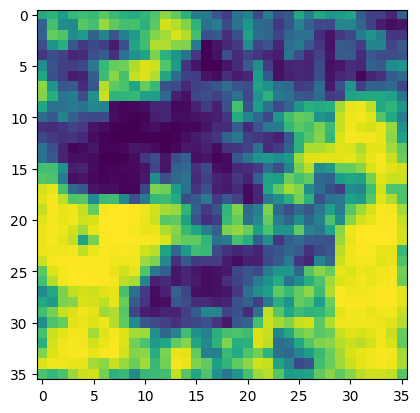

In [10]:
final_img = np.squeeze(conv_outputs[3])

from matplotlib.pyplot import imshow

imshow(final_img)

In [31]:
import tensorflow as tf
import pandas as pd
tf.version
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) #GPUs

# GPUs Available:  1


In [9]:
print(o)
print(y_test)

[1 0 3 1 2 1 2 3 3 2 3 1 2 0 2 3 2 1 0 1 2 3 1 1 2 1 0 1 1 2 0 3 2 2 0 3 1
 3 2 0 1 3 2 3 2 3 1 2 1 3 1 2 0 2 2 0 1 3 1 3 3 0 1 3 3 3 3 0 0 2 2 1 1 1
 2 0 1 0 0 1 1 0 1 3 3]
[1 0 3 1 2 1 2 3 1 2 3 3 2 0 2 1 2 1 0 1 0 3 1 0 2 1 0 1 1 2 0 3 2 2 0 3 1
 3 2 0 3 3 2 3 2 1 1 2 1 3 3 2 0 2 2 0 1 3 1 1 3 0 3 3 3 3 3 0 0 2 2 1 1 1
 2 0 1 0 0 3 1 0 1 1 0]


In [11]:
!pip install scikit-learn

     ---------------------------------------- 8.3/8.3 MB 24.1 MB/s eta 0:00:00
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
     --------------------------------------- 42.5/42.5 MB 22.6 MB/s eta 0:00:00
     ------------------------------------- 298.0/298.0 kB 18.0 MB/s eta 0:00:00


In [12]:
import sklearn

In [13]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, o)
print(conf_matrix)

[[16  1  1  1]
 [ 0 20  0  5]
 [ 0  0 20  0]
 [ 0  5  0 16]]


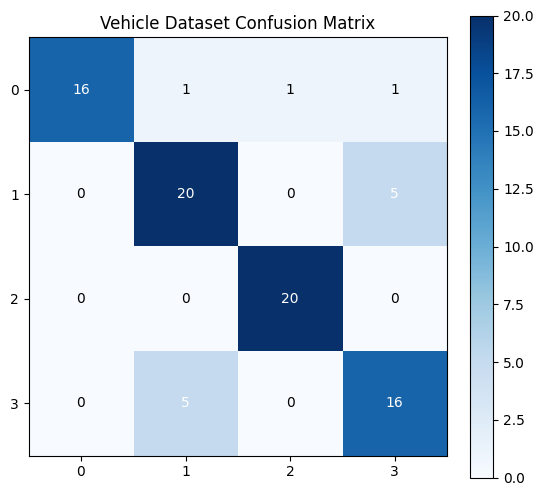

In [20]:
title = 'Vehicle Dataset Confusion Matrix'
cmap=plt.cm.viridis
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))  # , cmap=plt.cm.Greens
plt.title(title, size=12)
plt.colorbar(fraction=0.05, pad=0.05)
tick_marks = np.arange(3, 3)
plt.xticks(np.arange(4), ('0', '1', '2', '3'))
plt.yticks(np.arange(4), ('0', '1', '2', '3'))

fmt = 'd' 
thresh = 1
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 ha="center", va="center", color="white" if conf_matrix[i, j] > thresh else "black")  #horizontalalignment